## Latency prediction under training inference co-working

### I. data preparation

In [15]:
import pandas as pd
import numpy as np
import os
import re
root ='./data'

def str2dict(file_name):
    arg_list = ['arch','workers', 'epochs','batch_size', 'image_size', 'device']
    config= file_name[0].split('+')
    train_args = re.findall(r'Train (.+)',config[0].strip())[0].split(' ')
    infer_args = re.findall(r'Infer (.+)',config[1].strip())[0].split(' ')
    train_dict ={}
    infer_dict ={}
    for arg in arg_list:
        for arg_val in train_args:
            if re.match(arg, arg_val):
                val = re.findall(arg+'_(.+)', arg_val)[0]
                train_dict[arg]=val
        for arg_val in infer_args:
            if re.match(arg, arg_val):
                val = re.findall(arg+'_(.+)', arg_val)[0]
                infer_dict[arg]=val
    return train_dict, infer_dict
# train_dict, infer_dict = str2dict(file_name)
# print(train_dict, infer_dict)

def dict_str2value(dict_old):
    model_list =  ['deeplab_v3', 'yolo_v5s', 'alexnet','densenet201','mobilenet_v2','resnet152','shufflenet_v2_x1_0', 'squeezenet1_0', 'vgg16']
    model_map = {}
    for i, model_name in enumerate(model_list): model_map[model_name] = i
    dict_new ={}
    for arg, val in dict_old.items():
        if arg=='arch':
            dict_new['arch']=model_map[val]
        elif arg == 'device':
            dict_new['device']= 1 if dict_old['device'] == 'cuda' else 0
        else: 
            dict_new[arg] = int(val)
    return dict_new

def dict_str2value_partial(dict_old):
    model_list =  ['deeplab_v3', 'yolo_v5s', 'alexnet','densenet201','mobilenet_v2','resnet152','shufflenet_v2_x1_0', 'squeezenet1_0', 'vgg16']
    model_map = {}
    for i, model_name in enumerate(model_list): model_map[model_name] = i
    dict_new ={}
    for arg, val in dict_old.items():
        if arg=='arch':
            dict_new['arch']=val
        elif arg == 'device':
            dict_new['device']= val
        else: 
            dict_new[arg] = int(val)
            dict_new[arg] = int(val)
    return dict_new

## columns to be added
train_col = ['arch', 'workers', 'epochs', 'batch_size', 'image_size', 'device']
infer_col = ['arch', 'workers', 'batch_size', 'image_size', 'device']
trn_col, inf_col =[], []
for col in train_col: trn_col.append('trn_'+col)
for col in infer_col: inf_col.append('inf_'+col)
add_col= trn_col+inf_col+['latency']
print(add_col)

['trn_arch', 'trn_workers', 'trn_epochs', 'trn_batch_size', 'trn_image_size', 'trn_device', 'inf_arch', 'inf_workers', 'inf_batch_size', 'inf_image_size', 'inf_device', 'latency']


In [16]:
## consolidate log's below folder's 

#logfile
log= pd.read_csv('./data/profiler_log_20230123200614.csv')


def parse_config(root, data_type, log_file):
    folder =os.path.join(root,'./',data_type)
    for file_name in os.listdir(folder):
        data =  pd.read_csv(os.path.join(folder,file_name))
    #     print(col)
        _file_name= re.findall(r'(.+)_20.+.csv', file_name)  # extract file name prefix
        train_dict, infer_dict = str2dict(_file_name)
        _train_dict = dict_str2value_partial(train_dict)  # change str to value, e.g. workers:'1'  to workers:1
        _infer_dict = dict_str2value_partial(infer_dict)
        record = log.where((log['train_configure']==str(_train_dict)) & \
                           (log['infer_configure']==str(_infer_dict))).dropna()
        result = record['result'].to_list()[0] # convert serial to list to string
        result = re.findall(r'{(.+)}', result)[0]  # extract string in { }
        latency = float(result.split(':')[1])
        train_dict_value = dict_str2value(train_dict)
        infer_dict_value = dict_str2value(infer_dict)
        values = list(train_dict_value.values())+list(infer_dict_value.values())+[latency]
        data_new= data.copy()
        for i, col in enumerate(add_col):
            for j in range(len(data)):  # repeatedly add 500 instances
                data_new[col]=values[i]
        data_new.to_csv(os.path.join(root,data_type+'_data.csv'), index_label=None, mode='a')
        print(f'Configure values of {data_type} : {values}.')

for data_type in ['train', 'val','test']:
    parse_config(root, data_type, log)
print('Data generated!')

Configure values of train : [8, 1, 3, 8, 224, 1, 4, 1, 1, 448, 1, 8.617367607892527].
Configure values of train : [5, 1, 3, 32, 224, 1, 4, 1, 1, 448, 1, 8.18356553074557].
Configure values of train : [3, 1, 3, 4, 224, 1, 4, 1, 1, 448, 1, 7.48066907860456].
Configure values of train : [6, 1, 3, 16, 224, 1, 3, 1, 1, 448, 1, 26.77643119200301].
Configure values of train : [7, 1, 3, 2, 224, 1, 3, 1, 1, 448, 1, 27.45291703357445].
Configure values of train : [2, 1, 3, 1, 224, 1, 2, 1, 1, 448, 1, 3.3249535613705024].
Configure values of train : [4, 1, 3, 64, 224, 1, 3, 1, 1, 448, 1, 26.76214380845985].
Configure values of train : [8, 1, 3, 64, 224, 1, 2, 1, 1, 448, 1, 3.552546609068063].
Configure values of train : [8, 1, 3, 1, 224, 1, 3, 1, 1, 448, 1, 26.967275904393727].
Configure values of train : [4, 1, 3, 1, 224, 1, 4, 1, 1, 448, 1, 6.558520704341547].
Configure values of train : [2, 1, 3, 1, 224, 1, 4, 1, 1, 448, 1, 7.217156633344023].
Configure values of train : [5, 1, 3, 1, 224, 1, 2

Configure values of train : [4, 1, 3, 8, 224, 1, 3, 1, 1, 448, 1, 26.807793488569246].
Configure values of train : [7, 1, 3, 8, 224, 1, 3, 1, 1, 448, 1, 26.824604271827614].
Configure values of train : [3, 1, 3, 4, 224, 1, 3, 1, 1, 448, 1, 26.75045947145595].
Configure values of train : [0, 1, 3, 1, 224, 1, 3, 1, 1, 448, 1, 26.771869154212418].
Configure values of train : [0, 1, 3, 1, 224, 1, 1, 1, 1, 448, 1, 25.464385237126535].
Configure values of train : [7, 1, 3, 64, 224, 1, 3, 1, 1, 448, 1, 26.482917982557268].
Configure values of train : [8, 1, 3, 2, 224, 1, 1, 1, 1, 448, 1, 29.46310041928657].
Configure values of train : [3, 1, 3, 32, 224, 1, 3, 1, 1, 448, 1, 27.297812248776633].
Configure values of train : [0, 1, 3, 4, 224, 1, 3, 1, 1, 448, 1, 26.39173870700294].
Configure values of train : [8, 1, 3, 4, 224, 1, 2, 1, 1, 448, 1, 3.425025881065215].
Configure values of train : [8, 1, 3, 16, 224, 1, 2, 1, 1, 448, 1, 3.519529190962818].
Configure values of train : [6, 1, 3, 2, 224,

Configure values of test : [6, 1, 3, 4, 224, 1, 2, 1, 1, 448, 1, 2.7300352308683196].
Configure values of test : [2, 1, 3, 256, 224, 1, 2, 1, 1, 448, 1, 2.822004654091595].
Configure values of test : [0, 1, 3, 4, 224, 1, 1, 1, 1, 448, 1, 25.476056914828913].
Configure values of test : [2, 1, 3, 4, 224, 1, 2, 1, 1, 448, 1, 2.924458459553681].
Configure values of test : [2, 1, 3, 8, 224, 1, 2, 1, 1, 448, 1, 2.9275447713087326].
Configure values of test : [6, 1, 3, 16, 224, 1, 1, 1, 1, 448, 1, 23.596322023843065].
Configure values of test : [6, 1, 3, 256, 224, 1, 4, 1, 1, 448, 1, 6.844241222007459].
Configure values of test : [7, 1, 3, 128, 224, 1, 4, 1, 1, 448, 1, 6.999055391209609].
Configure values of test : [7, 1, 3, 128, 224, 1, 2, 1, 1, 448, 1, 2.9122733306663253].
Configure values of test : [4, 1, 3, 64, 224, 1, 2, 1, 1, 448, 1, 2.968949907911629].
Configure values of test : [0, 1, 3, 8, 224, 1, 4, 1, 1, 448, 1, 7.654530101410442].
Configure values of test : [0, 1, 3, 4, 224, 1, 2,

## II. data analysis

In [11]:
import pandas as pd
import numpy as np
import os

## load data 
dataset_train = pd.read_csv(os.path.join(root, 'train_data.csv'), index_col = None)
dataset_train =  dataset_train.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1)
dataset_val = pd.read_csv(os.path.join(root, 'val_data.csv'), index_col = None)#[:,2:] filter unnamed cols
dataset_val =  dataset_val.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1) 
dataset_test = pd.read_csv(os.path.join(root, 'test_data.csv'), index_col = None)
dataset_test =  dataset_test.drop(['gpu_name', 'time_stamp','timestamp' ], axis=1)
dataset_train= dataset_train[dataset_train['gpu_power']!='gpu_power'].dropna()  # drop off rows of column names
dataset_val= dataset_val[dataset_val['gpu_power']!='gpu_power'].dropna()
dataset_test= dataset_test[dataset_test['gpu_power']!='gpu_power'].dropna()

y_train = dataset_train.iloc[:,-1]
x_train = dataset_train.iloc[:,:-1]
y_valid = dataset_val.iloc[:,-1]
x_valid = dataset_val.iloc[:,:-1]


for col in dataset_val.columns: 
    dataset_val[col] = pd.to_numeric( dataset_val[col])
for col in dataset_train.columns: 
    dataset_train[col] = pd.to_numeric( dataset_train[col])
    
print(dataset_val.columns)
print(dataset_train.iloc[0])

# view some data

ParserError: Error tokenizing data. C error: Expected 45 fields in line 13002, saw 47


Epoch 1/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0293 - val_loss: 0.2450
Epoch 2/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0239 - val_loss: 0.2021
Epoch 3/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0235 - val_loss: 0.2179
Epoch 4/20
12500/12500 [==============================] - 17s 1ms/step - loss: 0.0233 - val_loss: 0.2369
Epoch 5/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0232 - val_loss: 0.2383
Epoch 6/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0231 - val_loss: 0.2700
Epoch 7/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0231 - val_loss: 0.2562
Epoch 8/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0231 - val_loss: 0.2622
Epoch 9/20
12500/12500 [==============================] - 18s 1ms/step - loss: 0.0231 - val_loss: 0.2240
Epoch 10/20
12500/12500 [==============================

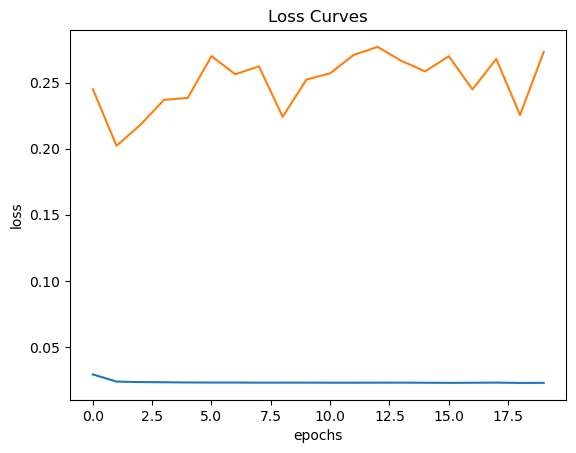

875/875 [==============================] - 1s 818us/step


In [6]:
#coding:utf-8
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

class data_utils():
    def __init__(self):
        pass

    def minmax_scale(self,dataset):

        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(dataset)
        dataset = min_max_scaler.transform(dataset)
        return dataset
 
    def minmax_scale_inverse(self,y_valid,y_new):

        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(y_valid)
        y_new_TURE = min_max_scaler.inverse_transform(y_new)
        return y_new_TURE

class neural_network():
    def __init__(self,epochs= 20,batch_size=8,verbose=1,loss='mse',optimizer='adam'):
        self.epochs = epochs          
        self.batch_size = batch_size  
        self.verbose = verbose        
        self.loss = loss              
        self.optimizer = optimizer    

    def train_nn(self,x_train, y_train,x_valid, y_valid):

        model = Sequential()  
        model.add(Dense(units = 10,                      
                        activation='linear',             
                        input_shape=(x_train.shape[1],)  
                        ))
        model.add(Dropout(0.2))  
        model.add(Dense(units = 1,  activation='linear')) 
        model.compile(loss=self.loss,optimizer=self.optimizer,) 
        history = model.fit(x_train, y_train,  epochs=self.epochs, 
                            batch_size=self.batch_size, 
                            verbose=self.verbose, 
                            validation_data = (x_valid, y_valid)) 
 
        plt.title('Loss Curves')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.show()

        model.save('nn_model.h5') 

    def predict_nn(self,x_test):

        model = load_model('nn_model.h5')
        y_new = model.predict(x_test)
        return y_new

def main(dataset_train, dataset_val):

    du = data_utils()
    nn = neural_network()     

    y_train = dataset_train.iloc[:,-1].to_numpy().reshape(-1, 1)
    x_train = dataset_train.iloc[:,:-1].to_numpy()
    y_valid = dataset_val.iloc[:,-1].to_numpy().reshape(-1, 1)
    x_valid = dataset_val.iloc[:,:-1].to_numpy()
    
    x_train = du.minmax_scale(x_train)   
    y_train = du.minmax_scale(y_train)   
    x_valid = du.minmax_scale(x_valid)   
    y_valid = du.minmax_scale(y_valid)    

    nn.train_nn(x_train, y_train,x_valid, y_valid) 
    pre_new = nn.predict_nn(x_valid)               
    pre_new = du.minmax_scale_inverse(y_valid, pre_new) 

if __name__ == "__main__":
    main(dataset_train, dataset_val)

### backup

In [18]:
## get inference time
import pandas as pd
log= pd.read_csv('./data/profiler_log.csv')
log

,Unnamed: 0,time_frame,train_configure,infer_configure,status,result
0,1,1.674091e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 16.18007766597196}
1,2,1.674092e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 15.969569237430791}
2,3,1.674092e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 16.01557815458632}
3,4,1.674092e+09,"{'arch': 'deeplab_v3', 'workers': 1, 'epochs':...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Fail,"Traceback (most recent call last):\n File ""/h..."
4,5,1.674093e+09,"{'arch': 'alexnet', 'workers': 1, 'epochs': 3,...","{'arch': 'yolo_v5', 'workers': 1, 'batch_size'...",Sucess,{'latency': 14.060524985394178}
...,...,...,...,...,...,...
229,230,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."
230,231,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."
231,232,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."
232,233,1.674110e+09,"{'arch': 'vgg16', 'workers': 1, 'epochs': 3, '...","{'arch': 'vgg16', 'workers': 1, 'batch_size': ...",Fail,"Traceback (most recent call last):\n File ""/h..."


In [27]:
a="{'arch': 'alexnet', 'workers': 1, 'epochs': 3, 'batch_size': 128, 'image_size': 224, 'device': 'cuda'}"
b="{'arch': 'yolo_v5', 'workers': 1, 'batch_size': 1, 'image_size': 224, 'device': 'cuda'}"

In [ ]:
{'arch': 'alexnet', 'workers': 1, 'epochs': 3, 'batch_size': 1024, 'image_size': 224, 'device': 'cuda'}